In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Tensorflow functions

In [36]:
def accuracy(Y,P):
    return (Y==P).mean()
def one_hot_encoder(v):
    return np.eye(v.max()+1)[v]
def one_hot_decoder(v):
    return tf.argmax(v,axis=1)
def populate_W(X,T,net_structure,stddev=0.01):
    net_structure=[X[0].size]+net_structure+[T[0].size]
    W=[]
    for i in range(len(net_structure)-1):
        W.append(tf.Variable(tf.random_normal([net_structure[i]+1,net_structure[i+1]],stddev=stddev)))
    return W
def process_layer(X,W):
    return tf.matmul(X,W[:-1])+W[-1]
def forward(X,W,f_transfer=tf.nn.sigmoid,f_output=lambda v: v):
    v=X
    for l in range(len(W)-1):
        v=f_transfer(process_layer(v,W[l]))
    v=f_output(process_layer(v,W[-1]))
    return v
def train(X,Y,net_structure,W_0=None,
          f_encode_Y=one_hot_encoder,
          f_decode_Y=one_hot_decoder,
          f_transfer=tf.nn.sigmoid,
          f_output=lambda v: v,
          f_accuracy=accuracy,
          frac_test=0.2,random_state=None,
          learning_rate=0.05,num_rounds=10000,
          report_step=100,print_every=1000,print_acc=True,plot_acc=True):
    reports=[]
    X,Y=sklearn.utils.shuffle(X,Y,random_state=random_state)
    num_test=int(frac_test*X.shape[0])
    X_train,Y_train=X[:-num_test],Y[:-num_test]
    X_test,Y_test=X[-num_test:],Y[-num_test:]
    T_train,T_test=f_encode_Y(Y_train),f_encode_Y(Y_test)
    if W_0!=None:
        W=W_0
    else:
        W=populate_W(X_train,T_train,net_structure)
    tfX=tf.placeholder(tf.float32,[None,X_train[0].size])
    tfY=tf.placeholder(tf.float32,[None,T_train[0].size])
    f_pred=forward(tfX,W,f_transfer,f_output)
    cost_wrapper=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tfY,logits=f_pred))
    train_wrapper=tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_wrapper)
    predict_wrapper=f_decode_Y(f_pred)
    sess=tf.Session()
    init=tf.global_variables_initializer()
    sess.run(init)
    for n in range(num_rounds):
        sess.run(train_wrapper,feed_dict={tfX:X_train,tfY:T_train})
        preds_train,preds_test=sess.run(predict_wrapper,feed_dict={tfX:X_train}),sess.run(predict_wrapper,feed_dict={tfX:X_test})
        if n % report_step==0:
            acc_train,acc_test=f_accuracy(Y_train,preds_train),f_accuracy(Y_test,preds_test)
            if print_every and n % print_every==0:
                print("{:5d} {:0.5f} {:0.5f}".format(n,acc_train,acc_test))
            reports.append([n,acc_train,acc_test])
    acc_train,acc_test=f_accuracy(Y_train,preds_train),f_accuracy(Y_test,preds_test)
    reports.append((num_rounds,acc_train,acc_test))
    if plot_acc:
        plt.plot([r[1] for r in reports])
        plt.plot([r[2] for r in reports])
        plt.show()
    return [sess.run(w) for w in W],reports

# 2D, multiclass data

In [4]:
num_classes=3
num_per_class=500
r=3*num_classes/math.pi
d=2*math.pi/num_classes
centers=[[r*math.cos(n*d),r*math.sin(n*d)] for n in range(num_classes)]
X_lst=[]
for c in range(num_classes):
    X_lst.append(np.random.randn(num_per_class,2) + np.array(centers[c]))
X_class=np.concatenate(X_lst,axis=0)
Y_class=np.array([ co for l in [[cl]*num_per_class for cl in range(num_classes)] for co in l ])

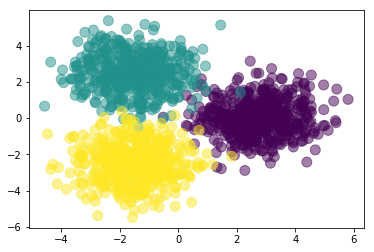

In [5]:
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

## Modeling

    0 0.33667 0.32000
 1000 0.98750 0.97667
 2000 0.98833 0.98000
 3000 0.98833 0.98000
 4000 0.98833 0.98000
 5000 0.98833 0.98000
 6000 0.98833 0.98000
 7000 0.98833 0.98000
 8000 0.98833 0.98000
 9000 0.98833 0.98000


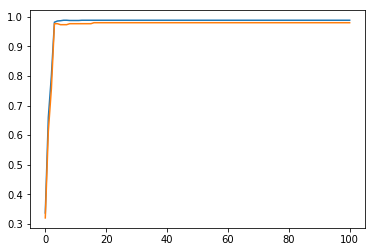

In [37]:
W,reports=train(X_class,Y_class,[4],W_0=None,
                learning_rate=0.05,num_rounds=10000,
                report_step=100,print_every=1000)

# Donut chunks - imbalanced classes

In [51]:
num_donuts=2
num_chunks=2
avg_num_per_chunk=500
overlap=0.1
tot_num=num_donuts*num_chunks*avg_num_per_chunk
min_r=1
max_r=num_donuts+1
tot_area=math.pi*(max_r**2-min_r**2)
density=1.0*tot_num/tot_area
X_lst=[]
Y_lst=[]
for donut in range(num_donuts):
    min_donut_r=donut+1
    max_donut_r=donut+2
    donut_area=math.pi*(max_donut_r**2-min_donut_r**2)
    d_lims=sorted(list(np.random.uniform(size=num_chunks)))
    d_lims.append(d_lims[0]+1)
    for chunk in range(num_chunks):
        chunk_area=donut_area*(d_lims[chunk+1]-d_lims[chunk])
        num_in_chunk=int(density*chunk_area)
        r=np.random.uniform(size=num_in_chunk)+(1-overlap)*donut+1
        d=2*math.pi*np.random.uniform(d_lims[chunk]  -overlap/(2*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      d_lims[chunk+1]+overlap/(2*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      size=num_in_chunk)
        X_lst.extend([[r[n]*math.cos(d[n]),r[n]*math.sin(d[n])] for n in range(num_in_chunk)])
        Y_lst.extend([donut*num_chunks+chunk]*num_in_chunk)
X_class=np.array(X_lst)
Y_class=np.array(Y_lst)

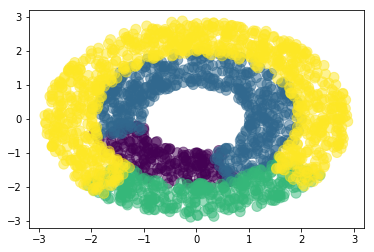

In [52]:
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

## Modeling

    0 0.44715 0.49123
 1000 0.57786 0.59900
 2000 0.56598 0.59900
 3000 0.83677 0.86717
 4000 0.87930 0.89724
 5000 0.89556 0.90727
 6000 0.89556 0.90977
 7000 0.90432 0.89975
 8000 0.90557 0.89975
 9000 0.91245 0.90977


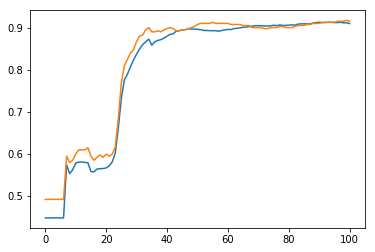

In [54]:
W,reports=train(X_class,Y_class,[8,8],W_0=None,
                learning_rate=0.5,num_rounds=10000,
                report_step=100,print_every=1000)